# Import

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import PIL
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms.functional as TF
from torchvision import transforms
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode
import shelve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm

# Setup for Training

In [4]:
images_train_path = '/content/gdrive/MyDrive/archive/Training' # change path if different

In [5]:
# define map so labels can created
map = {
    'glioma': 0,
    'meningioma': 1,
    'notumor': 2,
    'pituitary': 3,
    }

In [6]:
# make a list of tuples (filepath, label)
tumors = []
for i, name in enumerate(map.keys()):
  folder = os.listdir(os.path.join(images_train_path, name))
  for filename in folder:
    tumors.append((os.path.join(images_train_path, name, filename), map[name]))

# Dataset Class

In [7]:
# dataset class
class ResnetDataset(Dataset):
    def __init__(self, info, mode='default'):
        self.data = info
        self.mode = mode
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):

        pic = self.data[idx][0]
        lbl = self.data[idx][1]

        # since greyscale, all 3 channels should have same intensity, so take mean of per-channel normalizations
        mean = [np.mean([0.485, 0.456, 0.406])] * 3
        std = [np.mean([0.229, 0.224, 0.225])] * 3

        image = PIL.Image.open(pic).convert('L')
        image_np = np.array(image)
        image_rgb = np.stack([image_np, image_np, image_np], axis=-1)
        preprocess = v2.Compose([
            v2.ToImage(),
            v2.Resize(224, interpolation=InterpolationMode.BILINEAR),
            v2.CenterCrop(224),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        image = preprocess(image_rgb)

        if self.mode == 'default':
          label = torch.tensor([0, 0, 0, 0])
          label[lbl] = 1
        else:
          label = torch.tensor(lbl)

        return {'image': image.float(), 'label': label.float()}

In [8]:
# set model, criterion, optim
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
dset = ResnetDataset(tumors)
trainloader = DataLoader(dset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('done!')

done!


In [10]:
resnet50.to(device)
print('done!')

done!


# Training
**USE THIS**

---


Plotting train loss with epochs as the x- axis

In [11]:
# training loop
train_loss_mem = []
train_acc_mem = []
resnet50.train()
num_epochs = 15


for epoch in range(num_epochs):
  train_loss = 0.0
  train_correct = 0
  total_train = 0
  for data in tqdm(trainloader):
    images, labels = data['image'].to(device), torch.argmax(data['label'], dim=1).to(device)

    optimizer.zero_grad()
    out = resnet50(images)
    loss = criterion(out, labels)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()


    train_correct += (out.argmax(1) == labels).sum().item()
    total_train += labels.size(0)

    # Calculate average training loss and accuracy
  avg_train_loss = train_loss / len(trainloader)
  train_accuracy = train_correct / total_train
  train_loss_mem.append(avg_train_loss)
  train_acc_mem.append(train_accuracy)

  # save checkpoint, IMPORTANT: change name new version / diff model
  path = "/content/gdrive/My Drive/checkpoints/brain_v0_resnet50_{0}.ckpt".format(epoch) # look up format in python if unsure
  torch.save({
              'epoch': epoch,
              'model_state_dict': resnet50.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, path)

  0%|          | 0/212 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 212/212 [00:31<00:00,  6.78it/s]


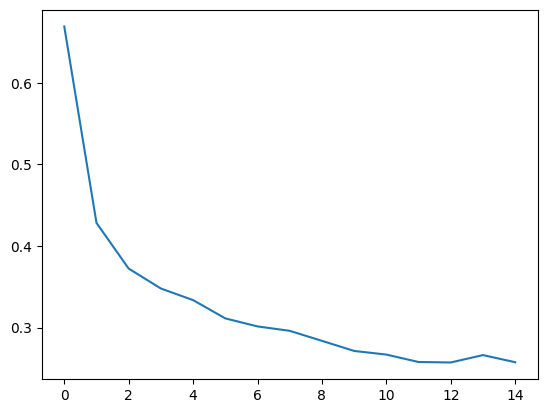

In [12]:
plt.plot(train_loss_mem)

# Different way of Training
**DO NOT RUN!!!! Just to show a different way to train the model with a different x-axis representation.**

---


Plotting train loss with iterations as the x- axis. Ran this code in a different runtime.

In [ ]:
'''
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)  #Specific to resnet

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
'''

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


In [ ]:
'''
dset = ResnetDataset(tumors)
trainloader = DataLoader(dset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('done!')
'''

done!


In [ ]:
'''
resnet50.to(device)
print('done!')
'''

done!


In [ ]:
'''
loss_mem = []
resnet50.train()
num_epochs = 5

for epoch in range(num_epochs):
  for data in tqdm(trainloader):
    images, labels = data['image'].to(device), data['label'].to(device)  # Access image and label directly from data dictionary



    optimizer.zero_grad()
    out = resnet50(images)
    loss = criterion(out, labels)

    loss.backward()
    optimizer.step()

    loss_mem.append(loss.data.item())

  # save checkpoint, IMPORTANT: change name new version / diff model
  path = "/content/gdrive/My Drive/checkpoints/brain_v0_resnet50_{0}.ckpt".format(epoch) # look up format in python if unsure
  torch.save({
              'epoch': epoch,
              'model_state_dict': resnet50.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, path)
'''

100%|██████████| 212/212 [00:51<00:00,  4.13it/s]


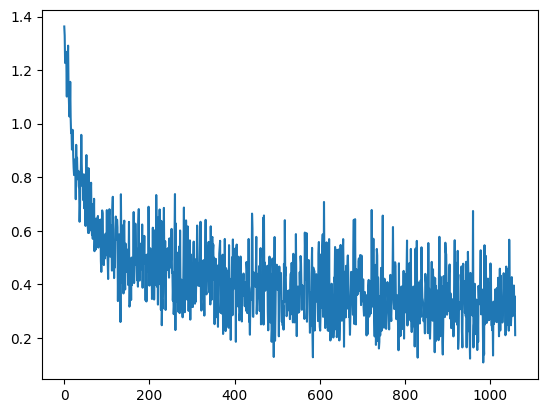

In [ ]:
'''
plt.plot(loss_mem)
'''

# Loading checkpoint (optional)

In [15]:
ckpt_path = '/content/gdrive/My Drive/checkpoints/brain_v0_resnet50_4.ckpt' # change path
checkpoint = torch.load(ckpt_path, map_location=torch.device(device))

resnet50.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

# Setup for Testing

In [16]:
images_test_path = '/content/gdrive/MyDrive/archive/Testing' # change path if different

In [17]:
# make a list of tuples (filepath, label)
test_tumors = []
for i, name in enumerate(map.keys()):
  folder = os.listdir(os.path.join(images_test_path, name))
  for filename in folder:
    test_tumors.append((os.path.join(images_test_path, name, filename), map[name]))

In [18]:
test_dset = ResnetDataset(test_tumors)
test_trainloader = DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Testing

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
test_losses = []
test_accuracies = []
predictions = []
true_labels = []

test_loss = 0.0
correct_test = 0
total_test = 0
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_matrix = np.zeros((4, 4), dtype=int)

with torch.no_grad():
    for data in tqdm(test_trainloader):
        images, labels = data['image'].to(device), torch.argmax(data['label'], dim=1).to(device)
        outp = resnet50(images)
        loss = criterion(outp, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outp, 1)
        predicted = predicted.unsqueeze(1)

        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1, 2, 3])

        total_test += labels.size(0)
        correct_test += (outp.argmax(1) == labels).sum().item()

        predictions.extend(outp.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    test_loss /= len(test_trainloader)
    test_accuracy = correct_test / total_test

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


  0%|          | 0/43 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 43/43 [01:56<00:00,  2.70s/it]


In [21]:
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 15/15, Train Loss: 0.2575, Train Accuracy: 0.9087, Test Loss: 0.3523, Test Accuracy: 0.8719


# Visualizing data

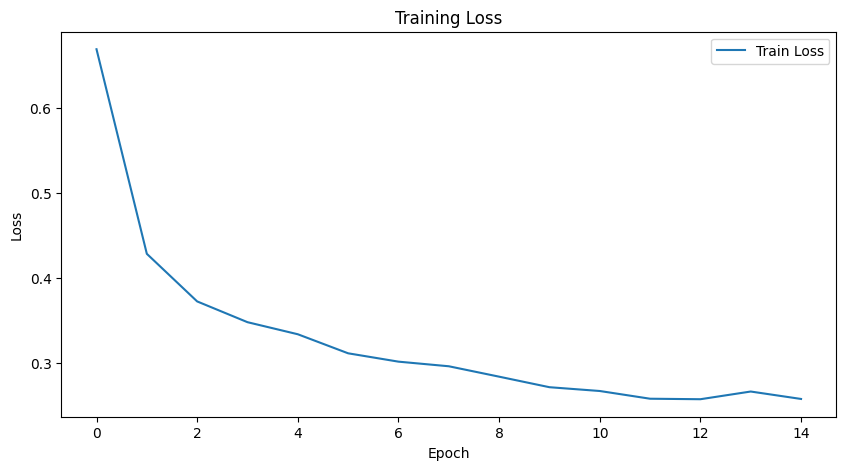

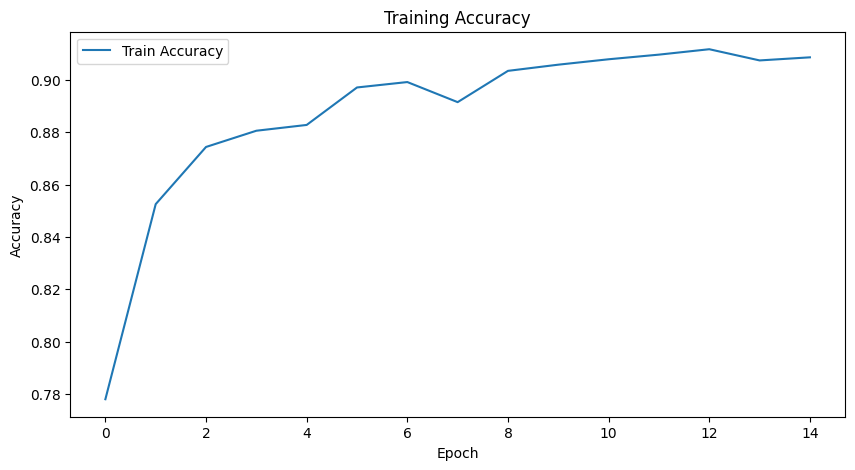

In [22]:
# plot Training loss and Training accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_mem, label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_mem, label='Train Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

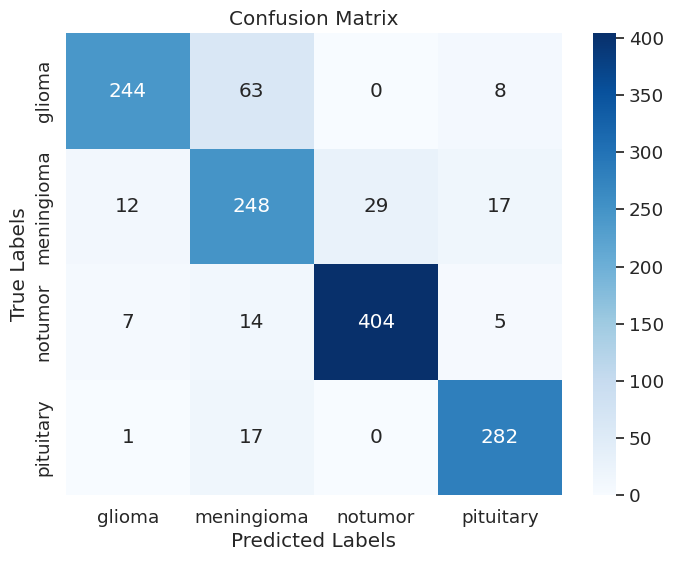

In [23]:
# confusion matrix
import seaborn as sns

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

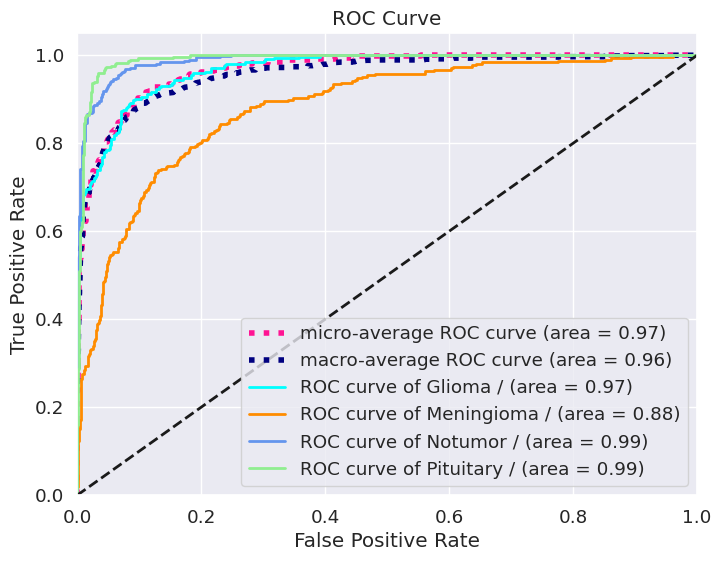

In [30]:
#ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Function to plot ROC curve
def plot_roc_curve(labels, predictions, num_classes):
    # Binarize the labels
    y_test = label_binarize(labels, classes=range(num_classes))
    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','lightgreen'])
    class_names = ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']  # Add names for each class
    for i, (color, class_name) in enumerate(zip(colors, class_names)):
      if i < num_classes:  # Ensure i doesn't exceed num_classes
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} / (area = {1:0.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predictions, num_classes=4)

# Experiment: TTA

In [26]:
# define tta transformations
class NoOperation: # still want to include the original image in the tta assembly, so have identity function
    def __call__(self, image):
        return image

tta_transforms = [
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=1),
    v2.RandomErasing(p=1, value='random', scale=(0.035, 0.035), ratio=(1, 1)),
    NoOperation(),
]

In [27]:
# tta eval
tta_true = []
tta_pred = []

with torch.no_grad():
    for data in tqdm(test_dset):
      image = data['image'] # dont need to unsqueeze since torch.stack will add nchw to chw tensor
      label = data['label']

      augs = torch.stack([t(image) for t in tta_transforms]).to(device)  # tta for 4 alterations
      outputs = resnet50(augs)
      preds = torch.argmax(outputs, dim=1)
      counts = torch.bincount(preds)

      tta_true.append(torch.argmax(label).item())
      tta_pred.append(torch.argmax(counts).item())

100%|██████████| 1351/1351 [00:24<00:00, 55.97it/s]


In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(tta_true, tta_pred)
print("TTA Accuracy:", accuracy)

TTA Accuracy: 0.850481125092524
